In [1]:
from collections import defaultdict
from random import random
import pysam
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

([<matplotlib.axis.XTick at 0x7f7f6e2fa410>,
 <a list of 3 Text xticklabel objects>)

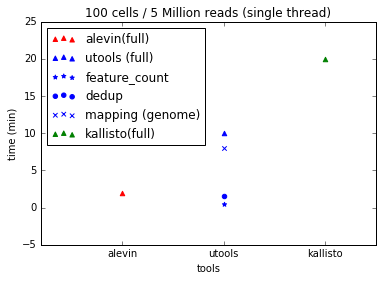

In [2]:
plt.scatter([1], [2], color='r', marker="^", label = "alevin(full)")
plt.scatter([2], [10], color='b', marker="^", label = "utools (full)")
plt.scatter([2], [.5], color='b', marker="*", label = "feature_count")
plt.scatter([2], [1.5], color='b', marker="o", label = "dedup")
plt.scatter([2], [8], color='b', marker="x", label = "mapping (genome)")
plt.scatter([3], [20], color='g', marker="^", label = "kallisto(full)")
plt.xlim([0.2, 3.5])
plt.legend(loc=2)
plt.ylabel('time (min)')
plt.xlabel('tools')
plt.title("100 cells / 5 Million reads (single thread)")
plt.xticks([1,2, 3], ['alevin', 'utools', 'kallisto'])

In [14]:
# def make_kal_reads(ifile, bc):
#     with open(ifile) as f, open('./input.umi', 'w') as uf, open('./reads.fastq', 'w') as rf:
#     for line in f:
#         toks = line.strip().split('_')
#         if (toks[1] == bc):
#             uf.write(toks[2]+"\n")
#             rf.write(line)
#             rf.write(f.next())
#             rf.write(f.next())
#             rf.write(f.next())            
#         else:
#             f.next()
#             f.next()
#             f.next()
# # make_kal_reads('./all_reads.fastq', 'GACTGCGAGGGCATGT')

In [15]:
def read_kal_out(t2gFile, txpList, ecMatFile, countTsvFile):
    with open(txpList) as f:
        tlist = pd.read_table(f, header=None).rename(columns={0:'tid'})
    with open(t2gFile) as f:
        t2g = pd.read_table(f, sep=",").set_index('TX_NAME').to_dict()['GENE_NAME']

    with open(countTsvFile) as f:
        counts = pd.DataFrame(pd.read_table(f, header=None).set_index(0)[2]).rename(columns={2:'counts'})
    sorted_idx = sorted(counts.to_dict()['counts'].keys())
    eqIdx = [0] * (sorted_idx[-1]+1)
    for elem in sorted_idx:
        eqIdx[elem] = 1
        
    kal_gene_count = defaultdict(int)
    other = 0
    eqCount = 0
    with open(ecMatFile) as f:
        for idx, line in enumerate(f):
            if eqIdx[idx]:
                eqCount += 1
                txps = line.strip().split()[1].split(',')
                gSet = set([])
                for txp in txps:
                    gSet.add(t2g[tlist.loc[int(txp)]['tid']])
                if len(gSet) == 1:
                    kal_gene_count[list(gSet)[0]] += counts.loc[idx]['counts']
                else:
                    other += counts.loc[idx]['counts']
        print eqCount
    
    kal_count = pd.DataFrame([kal_gene_count], columns=kal_gene_count.keys()).T.rename(columns={0:'kallisto'})
    return kal_count

In [16]:
def get_count(t, toks):
    gReads = 0
    baseIdx = t+2
    b = int(toks[baseIdx])
    for cIdx in range(2, 2*b+2, 2):
        if toks[baseIdx + cIdx - 1] == "GACTGCGAGGGCATGT":
            gReads += int(toks[baseIdx + cIdx])
    return gReads

def read_alv_out(countsAlvFile, t2gFile,dfname):
    cell_alv_data = defaultdict(int)
    
    with open(t2gFile) as f:
        t2g = pd.read_table(f, sep=",").set_index('TX_NAME').to_dict()['GENE_NAME']
    
    with open(countsAlvFile) as f:
        T = int(f.readline())
        E = int(f.readline())
        txps = []
        count = 0
        readCount = 0
        eqCount = 0
        beqCount = defaultdict(int)
        for _ in range(T):
            txps.append(f.readline().strip())

        for line in f:
            toks = line.strip().split()
            t = int(toks[0])
            eqCount += int(toks[t+1])
            if t == 1 :
                gId = t2g[txps[int(toks[t])]]
                bcount = get_count(t, toks)
                cell_alv_data[gId] += bcount
                beqCount['uniq'] += bcount
                continue

            gSet = set([])
            for tid in range(t):
                gSet.add(t2g[txps[int(toks[tid+1])]])
            if len(gSet) != 1:
                readCount += int(toks[t+1])
                count += 1
                bcount = get_count(t, toks)
                beqCount['ambig'] += bcount
            else:
                bcount = get_count(t, toks)
                beqCount['guniq'] += bcount
                cell_alv_data[list(gSet)[0]] += bcount
        print count, float(count)/E, readCount/5063782.0, eqCount, beqCount

    alv_count = pd.DataFrame([cell_alv_data], columns=cell_alv_data.keys()).T
    alv_count = alv_count[alv_count[0]!=0]
    alv_count = alv_count.rename(columns={0:dfname})
    return alv_count

In [17]:
def read_ut_out(utFile):
    ut_data = pd.read_table(open(utFile))
    cell_ut_data = ut_data[ut_data['cell'] == "GACTGCGAGGGCATGT"].set_index('gene')
    del cell_ut_data['cell']
    cell_ut_data = cell_ut_data.rename(columns={'count':'utools'})
    return cell_ut_data

In [38]:
def read_sal_out(sfFile, t2gFile):
    data = pd.DataFrame(pd.read_table(sfFile).set_index('Name')['NumReads'])
    
    with open(t2gFile) as f:
        t2g = pd.read_table(f, sep=",").set_index('TX_NAME')['GENE_NAME']
    
    ct = pd.concat([data, t2g], axis=1)
    gene_ct = ct.groupby('GENE_NAME').sum()
    return gene_ct[(gene_ct['NumReads'] != 0)].rename(columns={'NumReads':'salmon_alevin'})

In [19]:
#import data

In [20]:
with open('../../data/mohu/gtf/txp2gene.tsv') as f:
    t2g = pd.read_table(f, sep=",").groupby('GENE_NAME').first()

In [21]:
kal = read_kal_out("../../data/mohu/gtf/txp2gene.tsv", "./out/txpList.txt", "./out/matrix.ec", "./out/matrix.tsv")

17357


In [22]:
alv_cb = read_alv_out('../umi_cell_bias/alevin/counts.alv', "../../data/mohu/gtf/txp2gene.tsv", 'alv_bias')

2788 0.162121300227 0.00369861893739 109720 defaultdict(<type 'int'>, {'ambig': 16295, 'uniq': 12615, 'guniq': 59240})


In [37]:
alv_cnb = read_alv_out('../umi_cell_nobias/alevin/counts.alv', "../../data/mohu/gtf/txp2gene.tsv", 'alv_old')

2788 0.162121300227 0.00369861893739 109720 defaultdict(<type 'int'>, {'ambig': 16476, 'uniq': 12615, 'guniq': 59757})


In [39]:
sal = read_sal_out('../umi_out/alevin/quant.sf', "../../data/mohu/gtf/txp2gene.tsv")

In [40]:
utl = read_ut_out("../utools.count")

In [41]:
#analysis

In [42]:
#exp gene counts
len(alv_cb), len(alv_cnb), len(utl), len(kal), len(sal)

(7590, 7590, 7145, 7615, 9873)

In [47]:
#UMI count
ct = pd.concat([t2g, sal, utl, kal], axis=1)

del ct['TX_NAME']
ct = ct.fillna(0)
ct.sum()

salmon_alevin    88150.997498
utools           63856.000000
kallisto         72947.000000
dtype: float64

In [48]:
#correlation
ct.corr(method="spearman")

,salmon_alevin,utools,kallisto
salmon_alevin,1.000000,0.895288,0.923536
utools,0.895288,1.000000,0.936272
kallisto,0.923536,0.936272,1.000000


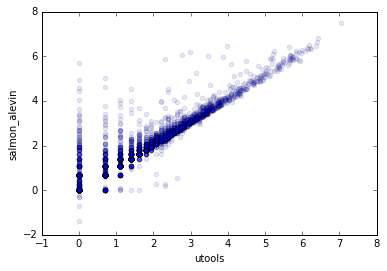

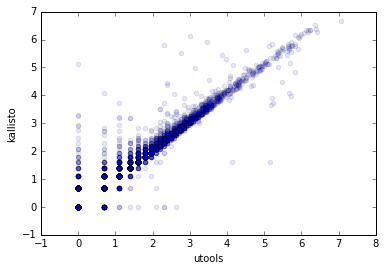

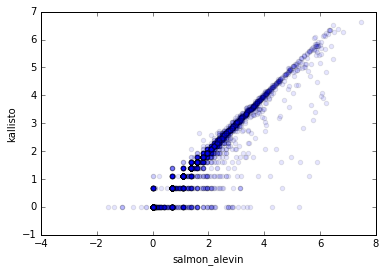

In [51]:
np.log(ct).plot.scatter('utools', 'salmon_alevin', alpha='0.1')
np.log(ct).plot.scatter('utools', 'kallisto', alpha='0.1')
np.log(ct).plot.scatter('salmon_alevin', 'kallisto', alpha='0.1')